In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import random
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [5]:
data = pd.read_csv("data/train_combined_dataset_all.csv")

In [6]:
data.info()
data.describe()
data.shape
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GOCI2_Latitude      10000 non-null  float64
 1   GOCI2_Longitude     10000 non-null  float64
 2   Himawari_Latitude   10000 non-null  float64
 3   Himawari_Longitude  10000 non-null  float64
 4   Chlorophyll         10000 non-null  float64
 5   Albedo_01           10000 non-null  float64
 6   Albedo_02           10000 non-null  float64
 7   Albedo_03           10000 non-null  float64
 8   Albedo_04           10000 non-null  float64
dtypes: float64(9)
memory usage: 703.2 KB
Index(['GOCI2_Latitude', 'GOCI2_Longitude', 'Himawari_Latitude',
       'Himawari_Longitude', 'Chlorophyll', 'Albedo_01', 'Albedo_02',
       'Albedo_03', 'Albedo_04'],
      dtype='object')


### output filtered csv

In [10]:
# 選擇所需的列
selected_columns = ['Albedo_01', 'Albedo_02', 'Albedo_03', 'Albedo_04', 'Chlorophyll']

# 過濾數據
filtered_data = data[selected_columns]

## 重命名列，去掉 '2km_'
#filtered_data.columns = ['albedo_01', 'albedo_02', 'albedo_03', 'albedo_04', 'CHL_a']
#
# 將過濾後的數據寫入新的CSV文件
filtered_data.to_csv("data/train_nn_filtered_data.csv", index=False)

print("新的 CSV 文件已成功輸出，文件名為 data/train_nn_filtered_data.csv")

新的 CSV 文件已成功輸出，文件名為 data/train_nn_filtered_data.csv


In [11]:
import pandas as pd

# 讀取CSV文件，確保資料的精度
df = pd.read_csv('data/train_nn_filtered_data.csv', encoding='utf-8-sig', dtype=str)

# 移除包含 '<' 符號的行
filtered_df = df[~df.apply(lambda row: row.str.contains('<|,').any(), axis=1)]

# 輸出篩選後的結果到新的CSV文件
filtered_df.to_csv('data/train_filtered_and_trimmed_data.csv', index=False, encoding='utf-8-sig')


In [13]:
data = pd.read_csv("data/train_filtered_and_trimmed_data.csv")
data.info()
data.describe()
data.shape
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Albedo_01    10000 non-null  float64
 1   Albedo_02    10000 non-null  float64
 2   Albedo_03    10000 non-null  float64
 3   Albedo_04    10000 non-null  float64
 4   Chlorophyll  10000 non-null  float64
dtypes: float64(5)
memory usage: 390.8 KB
Index(['Albedo_01', 'Albedo_02', 'Albedo_03', 'Albedo_04', 'Chlorophyll'], dtype='object')


In [15]:
print(data.Chlorophyll.count())
print(data.Albedo_01.count())
print(data.Albedo_02.count())
print(data.Albedo_03.count())
print(data.Albedo_04.count())

10000
10000
10000
10000
10000


In [17]:
train = data
train.info()
train.Chlorophyll.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Albedo_01    10000 non-null  float64
 1   Albedo_02    10000 non-null  float64
 2   Albedo_03    10000 non-null  float64
 3   Albedo_04    10000 non-null  float64
 4   Chlorophyll  10000 non-null  float64
dtypes: float64(5)
memory usage: 390.8 KB


Chlorophyll
0.287717    2
0.093096    2
0.484459    2
0.084032    2
0.096032    2
           ..
0.106502    1
0.522979    1
0.252160    1
0.224458    1
0.241589    1
Name: count, Length: 9993, dtype: int64

In [19]:
X = train.drop('Chlorophyll', axis=1)
y = train.Chlorophyll
y.value_counts()

Chlorophyll
0.287717    2
0.093096    2
0.484459    2
0.084032    2
0.096032    2
           ..
0.106502    1
0.522979    1
0.252160    1
0.224458    1
0.241589    1
Name: count, Length: 9993, dtype: int64

### Scalar

In [20]:
scaler = StandardScaler()
# scale the data to make it easier for the model to learn
X = scaler.fit_transform(X)

### Train

In [21]:
test_ratio = 0.2

random_seed = random.randint(1, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100,)],
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['tanh', 'relu']
}

In [22]:
# Create an MLPRegressor instance
mlp = MLPRegressor(solver='sgd', max_iter=200,
                   n_iter_no_change=10, tol=0.0001, verbose=1)

# Create a GridSearchCV instance
grid_mlp = GridSearchCV(
    mlp, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, cv=5)

# Fit the grid search to the data
grid_mlp.fit(X_train, y_train)

# Get the best estimator
optimized_mlp = grid_mlp.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Iteration 1, loss = 0.09437767
Iteration 2, loss = 0.06564933
Iteration 3, loss = 0.05681601
Iteration 4, loss = 0.05250336
Iteration 5, loss = 0.04901693
Iteration 6, loss = 0.04595479
Iteration 7, loss = 0.04511865
Iteration 8, loss = 0.04399353
Iteration 9, loss = 0.04267960
Iteration 10, loss = 0.04170392
Iteration 11, loss = 0.04222428
Iteration 12, loss = 0.04087335
Iteration 13, loss = 0.04117594
Iteration 14, loss = 0.04078564
Iteration 15, loss = 0.04046594
Iteration 16, loss = 0.04076232
Iteration 17, loss = 0.04029744
Iteration 18, loss = 0.04008960
Iteration 19, loss = 0.04009809
Iteration 20, loss = 0.04007657
Iteration 21, loss = 0.04004876
Iteration 22, loss = 0.03957860
Iteration 23, loss = 0.03959198
Iteration 24, loss = 0.03921444
Iteration 25, loss = 0.03945214
Iteration 26, loss = 0.03966841
Iteration 27, loss = 0.03914230
Iteration 28, loss = 0.03926506
Iteration 29, loss = 0.03913829
Iteration 30, loss 

In [23]:
# Print the best parameters found by the grid search
print("MLP best parameters:", grid_mlp.best_params_)

# Make predictions
MLP_train_pred = optimized_mlp.predict(X_train)
MLP_test_pred = optimized_mlp.predict(X_test)

# Calculate the desired metrics
train_mae = mean_absolute_error(y_train, MLP_train_pred)
test_mae = mean_absolute_error(y_test, MLP_test_pred)
train_rmse = sqrt(mean_squared_error(y_train, MLP_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, MLP_test_pred))
train_r2 = r2_score(y_train, MLP_train_pred)
test_r2 = r2_score(y_test, MLP_test_pred)

# Print the calculated metrics
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")


MLP best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.1}
Train MAE: 0.12678276980802766
Test MAE: 0.12702632651128837
Train RMSE: 0.2551880482813871
Test RMSE: 0.27320002750742206
Train R2: 0.637693522524784
Test R2: 0.5662661685558124


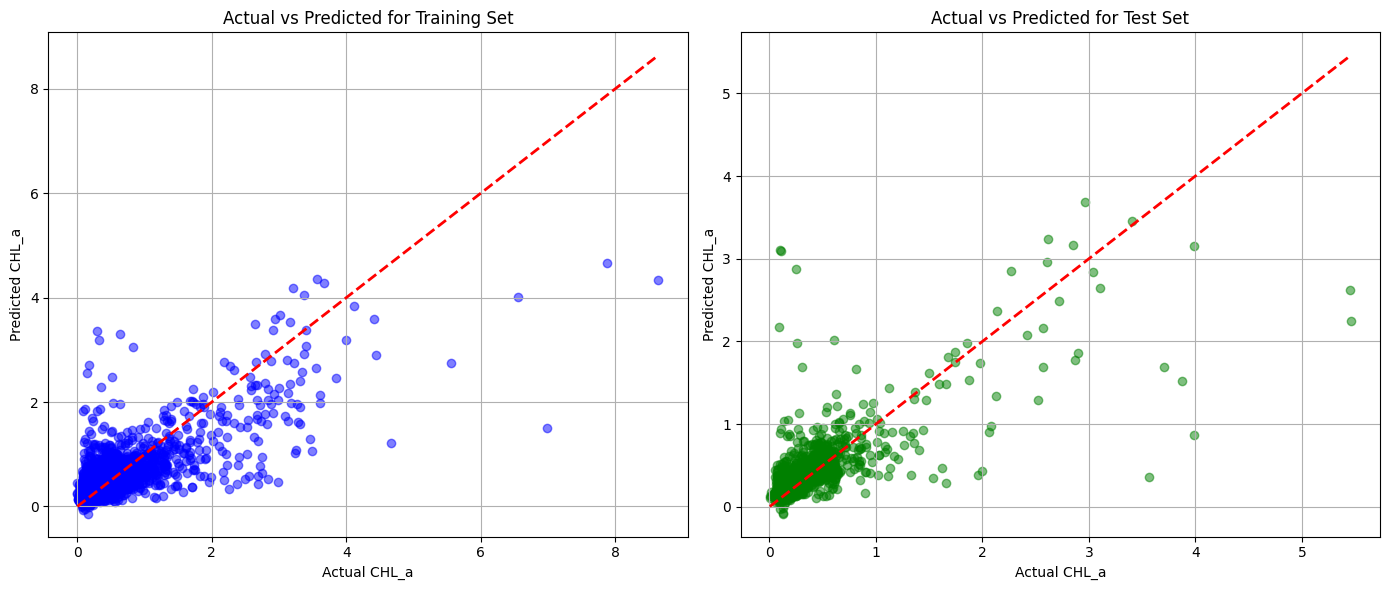

In [24]:
import matplotlib.pyplot as plt

# Assuming you have already run the previous code and have MLP_train_pred and MLP_test_pred ready

# Combine actual and predicted values for train and test sets
train_results = pd.DataFrame({'Actual': y_train, 'Predicted': MLP_train_pred})
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': MLP_test_pred})

# Plot actual vs predicted for the training set
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_results['Actual'], train_results['Predicted'], alpha=0.5, color='blue')
plt.plot([train_results['Actual'].min(), train_results['Actual'].max()], 
         [train_results['Actual'].min(), train_results['Actual'].max()], 'r--', lw=2)
plt.title('Actual vs Predicted for Training Set')
plt.xlabel('Actual CHL_a')
plt.ylabel('Predicted CHL_a')
plt.grid(True)

# Plot actual vs predicted for the test set
plt.subplot(1, 2, 2)
plt.scatter(test_results['Actual'], test_results['Predicted'], alpha=0.5, color='green')
plt.plot([test_results['Actual'].min(), test_results['Actual'].max()], 
         [test_results['Actual'].min(), test_results['Actual'].max()], 'r--', lw=2)
plt.title('Actual vs Predicted for Test Set')
plt.xlabel('Actual CHL_a')
plt.ylabel('Predicted CHL_a')
plt.grid(True)

plt.tight_layout()
plt.show()


MLP best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.1}
Train MAE: 0.12678276980802766
Test MAE: 0.12702632651128837
Train RMSE: 0.2551880482813871
Test RMSE: 0.27320002750742206
Train R2: 0.637693522524784
Test R2: 0.5662661685558124


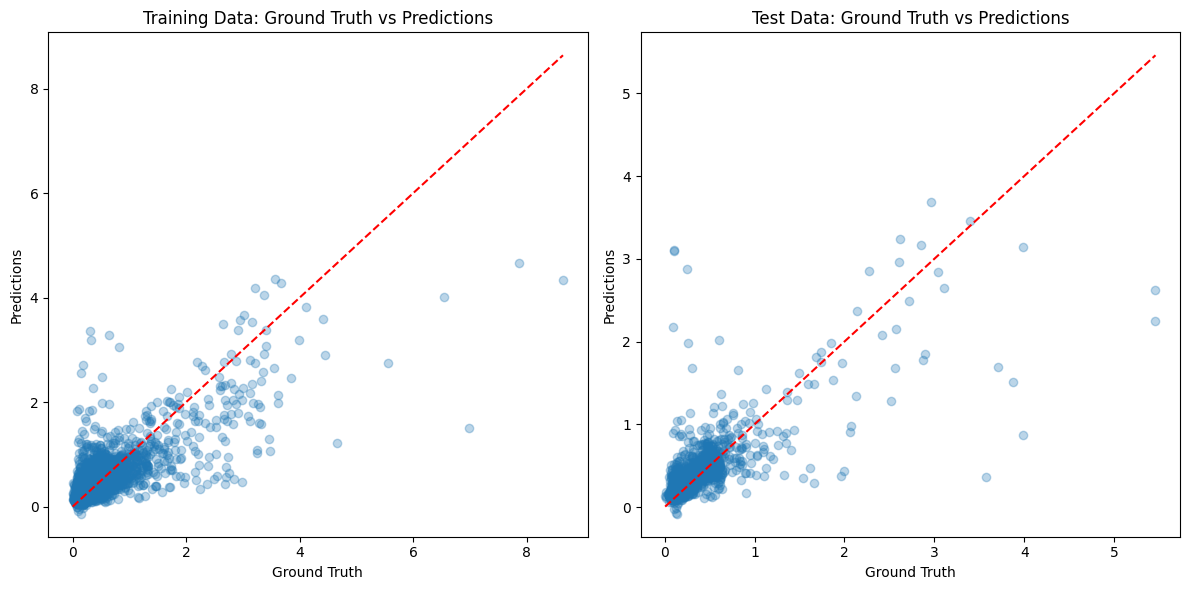

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Print the best parameters found by the grid search
print("MLP best parameters:", grid_mlp.best_params_)

# Make predictions
MLP_train_pred = optimized_mlp.predict(X_train)
MLP_test_pred = optimized_mlp.predict(X_test)

# Calculate the desired metrics
train_mae = mean_absolute_error(y_train, MLP_train_pred)
test_mae = mean_absolute_error(y_test, MLP_test_pred)
train_rmse = sqrt(mean_squared_error(y_train, MLP_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, MLP_test_pred))
train_r2 = r2_score(y_train, MLP_train_pred)
test_r2 = r2_score(y_test, MLP_test_pred)

# Print the calculated metrics
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

# Plot ground truth vs predictions for training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, MLP_train_pred, alpha=0.3)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Training Data: Ground Truth vs Predictions')

# Plot ground truth vs predictions for test data
plt.subplot(1, 2, 2)
plt.scatter(y_test, MLP_test_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Test Data: Ground Truth vs Predictions')

plt.tight_layout()
plt.show()


In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import random

# Data Preparation
X = data.drop('CHL_a', axis=1)
y = data['CHL_a']

scaler = StandardScaler()
X = scaler.fit_transform(X)

test_ratio = 0.2
random_seed = random.randint(1, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)

# Grid Search for Hyperparameter Tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu', 'tanh']
}

mlp = MLPRegressor(solver='adam', max_iter=500, n_iter_no_change=10, tol=0.0001, verbose=1)

grid_mlp = GridSearchCV(mlp, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
grid_mlp.fit(X_train, y_train)

optimized_mlp = grid_mlp.best_estimator_
print("MLP best parameters:", grid_mlp.best_params_)

MLP_train_pred = optimized_mlp.predict(X_train)
MLP_test_pred = optimized_mlp.predict(X_test)

train_mae = mean_absolute_error(y_train, MLP_train_pred)
test_mae = mean_absolute_error(y_test, MLP_test_pred)
train_rmse = sqrt(mean_squared_error(y_train, MLP_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, MLP_test_pred))
train_r2 = r2_score(y_train, MLP_train_pred)
test_r2 = r2_score(y_test, MLP_test_pred)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")


KeyError: "['CHL_a'] not found in axis"

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Iteration 1, loss = 6.84867445
Iteration 2, loss = 6.05200403
Iteration 3, loss = 5.55835821
Iteration 4, loss = 5.36130924
Iteration 5, loss = 5.36149946
Iteration 6, loss = 5.33934873
Iteration 7, loss = 5.32032943
Iteration 8, loss = 5.31755574
Iteration 9, loss = 5.31135014
Iteration 10, loss = 5.30527410
Iteration 11, loss = 5.30020835
Iteration 12, loss = 5.29751545
Iteration 13, loss = 5.29015821
Iteration 14, loss = 5.29818251
Iteration 15, loss = 5.29516852
Iteration 16, loss = 5.28706509
Iteration 17, loss = 5.28394484
Iteration 18, loss = 5.28290542
Iteration 19, loss = 5.28383335
Iteration 20, loss = 5.28090513
Iteration 21, loss = 5.27760291
Iteration 22, loss = 5.27626956
Iteration 23, loss = 5.27790115
Iteration 24, loss = 5.27368579
Iteration 25, loss = 5.28100643
Iteration 26, loss = 5.27521228
Iteration 27, loss = 5.27740519
Iteration 28, loss = 5.27879798
Iteration 29, loss = 5.27313587
Iteration 30, loss 

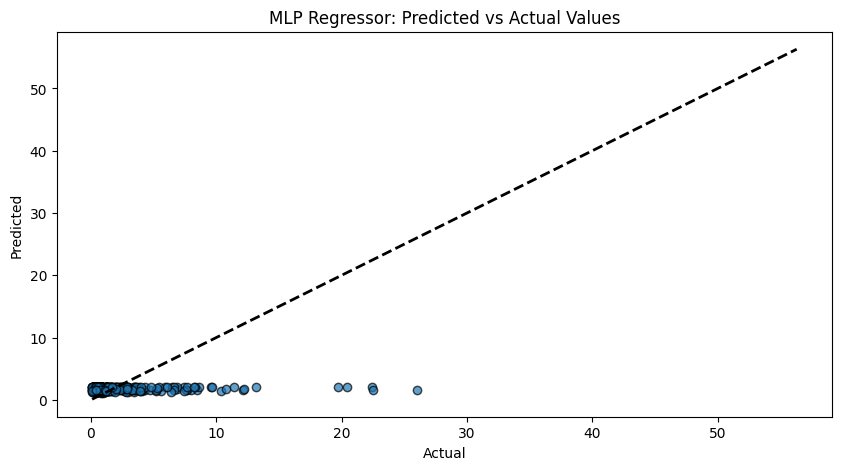

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import random

# Data Preparation
X = data.drop('CHL_a', axis=1)
y = data['CHL_a']

# Transform features to reduce skewness and outliers
pt = PowerTransformer()
X_transformed = pt.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Split data
test_ratio = 0.2
random_seed = random.randint(1, 100)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_ratio, random_state=42)

# Grid Search for Hyperparameter Tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu', 'tanh']
}

mlp = MLPRegressor(solver='adam', max_iter=1000, n_iter_no_change=10, tol=0.0001, verbose=1)

grid_mlp = GridSearchCV(mlp, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
grid_mlp.fit(X_train, y_train)

optimized_mlp = grid_mlp.best_estimator_
print("MLP best parameters:", grid_mlp.best_params_)

MLP_train_pred = optimized_mlp.predict(X_train)
MLP_test_pred = optimized_mlp.predict(X_test)

train_mae = mean_absolute_error(y_train, MLP_train_pred)
test_mae = mean_absolute_error(y_test, MLP_test_pred)
train_rmse = sqrt(mean_squared_error(y_train, MLP_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, MLP_test_pred))
train_r2 = r2_score(y_train, MLP_train_pred)
test_r2 = r2_score(y_test, MLP_test_pred)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

# Plotting predicted vs actual values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, MLP_test_pred, edgecolor='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('MLP Regressor: Predicted vs Actual Values')
plt.show()


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Iteration 1, loss = 6.32653626
Iteration 2, loss = 5.69080226
Iteration 3, loss = 5.46073614
Iteration 4, loss = 5.34672596
Iteration 5, loss = 5.33626763
Iteration 6, loss = 5.32460802
Iteration 7, loss = 5.31523782
Iteration 8, loss = 5.31045129
Iteration 9, loss = 5.31308848
Iteration 10, loss = 5.30990993
Iteration 11, loss = 5.30044418
Iteration 12, loss = 5.30324241
Iteration 13, loss = 5.30220293
Iteration 14, loss = 5.29472935
Iteration 15, loss = 5.29361552
Iteration 16, loss = 5.29333172
Iteration 17, loss = 5.29046711
Iteration 18, loss = 5.28574016
Iteration 19, loss = 5.29149080
Iteration 20, loss = 5.28518508
Iteration 21, loss = 5.28530150
Iteration 22, loss = 5.28303725
Iteration 23, loss = 5.28363710
Iteration 24, loss = 5.28638064
Iteration 25, loss = 5.28146666
Iteration 26, loss = 5.27316044
Iteration 27, loss = 5.28026424
Iteration 28, loss = 5.27515379
Iteration 29, loss = 5.27823228
Iteration 30, loss 

c:\Users\DIC\anaconda3\envs\ocean\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\DIC\anaconda3\envs\ocean\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\DIC\anaconda3\envs\ocean\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\DIC\anaconda3\envs\ocean\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\DIC\anaconda3\envs\ocean\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27512 (\N{CJK UNIFIED IDE

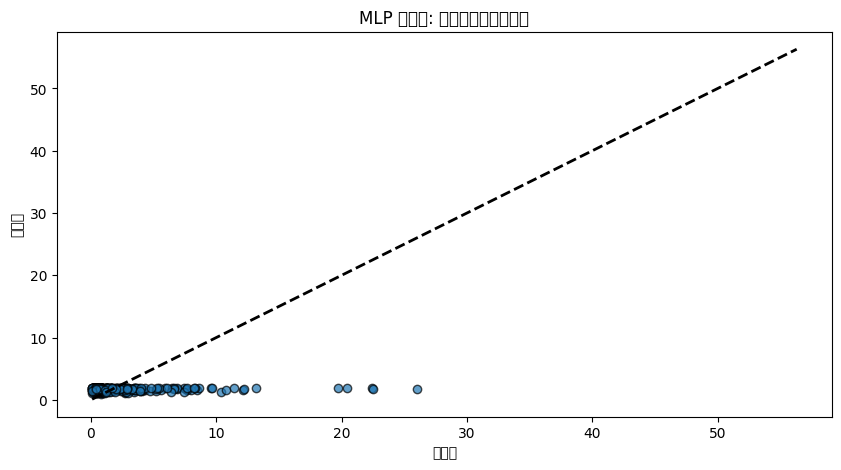

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import random

# 數據準備
X = data.drop('CHL_a', axis=1)
y = data['CHL_a']

# 轉換特徵以減少偏斜和離群值
pt = PowerTransformer()
X_transformed = pt.fit_transform(X)

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# 拆分數據
test_ratio = 0.2
random_seed = random.randint(1, 100)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_ratio, random_state=42)

# 超參數調優的網格搜索
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu', 'tanh']
}

mlp = MLPRegressor(solver='adam', max_iter=1000, n_iter_no_change=10, tol=0.0001, verbose=1)

grid_mlp = GridSearchCV(mlp, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
grid_mlp.fit(X_train, y_train)

optimized_mlp = grid_mlp.best_estimator_
print("MLP 最佳參數:", grid_mlp.best_params_)

MLP_train_pred = optimized_mlp.predict(X_train)
MLP_test_pred = optimized_mlp.predict(X_test)

train_mae = mean_absolute_error(y_train, MLP_train_pred)
test_mae = mean_absolute_error(y_test, MLP_test_pred)
train_rmse = sqrt(mean_squared_error(y_train, MLP_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, MLP_test_pred))
train_r2 = r2_score(y_train, MLP_train_pred)
test_r2 = r2_score(y_test, MLP_test_pred)

print(f"訓練集 MAE: {train_mae}")
print(f"測試集 MAE: {test_mae}")
print(f"訓練集 RMSE: {train_rmse}")
print(f"測試集 RMSE: {test_rmse}")
print(f"訓練集 R2: {train_r2}")
print(f"測試集 R2: {test_r2}")

# 繪製預測值與實際值的圖表
plt.figure(figsize=(10, 5))
plt.scatter(y_test, MLP_test_pred, edgecolor='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.title('MLP 回歸器: 預測值與實際值對比')
plt.show()


## 嘗試錯誤

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the features and target
X = data.drop('CHL_a', axis=1)
y = data['CHL_a']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_ratio, random_state=42)


In [57]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Create a basic MLPRegressor instance
basic_mlp = MLPRegressor(hidden_layer_sizes=(100,), solver='sgd', max_iter=200, n_iter_no_change=10, tol=0.0001, verbose=1)

# Fit the basic model to the training data
basic_mlp.fit(X_train, y_train)

# Make predictions
train_pred_basic = basic_mlp.predict(X_train)
test_pred_basic = basic_mlp.predict(X_test)

# Calculate the desired metrics
train_mae_basic = mean_absolute_error(y_train, train_pred_basic)
test_mae_basic = mean_absolute_error(y_test, test_pred_basic)
train_rmse_basic = sqrt(mean_squared_error(y_train, train_pred_basic))
test_rmse_basic = sqrt(mean_squared_error(y_test, test_pred_basic))
train_r2_basic = r2_score(y_train, train_pred_basic)
test_r2_basic = r2_score(y_test, test_pred_basic)

print(f"Train MAE: {train_mae_basic}")
print(f"Test MAE: {test_mae_basic}")
print(f"Train RMSE: {train_rmse_basic}")
print(f"Test RMSE: {test_rmse_basic}")
print(f"Train R2: {train_r2_basic}")
print(f"Test R2: {test_r2_basic}")


Iteration 1, loss = 7.61649620
Iteration 2, loss = 6.86356437
Iteration 3, loss = 6.15516097
Iteration 4, loss = 5.70236956
Iteration 5, loss = 5.49662646
Iteration 6, loss = 5.39074233
Iteration 7, loss = 5.34375018
Iteration 8, loss = 5.32978171
Iteration 9, loss = 5.32287846
Iteration 10, loss = 5.31831951
Iteration 11, loss = 5.31571100
Iteration 12, loss = 5.31346509
Iteration 13, loss = 5.31164148
Iteration 14, loss = 5.30968280
Iteration 15, loss = 5.30898127
Iteration 16, loss = 5.30713327
Iteration 17, loss = 5.31131941
Iteration 18, loss = 5.31008551
Iteration 19, loss = 5.30562195
Iteration 20, loss = 5.30206215
Iteration 21, loss = 5.30020196
Iteration 22, loss = 5.29935654
Iteration 23, loss = 5.29976680
Iteration 24, loss = 5.29843628
Iteration 25, loss = 5.29697986
Iteration 26, loss = 5.29595210
Iteration 27, loss = 5.29447701
Iteration 28, loss = 5.29414781
Iteration 29, loss = 5.29540359
Iteration 30, loss = 5.29371381
Iteration 31, loss = 5.29083616
Iteration 32, los

In [58]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(100,), (150, 100, 50), (200, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['tanh', 'relu']
}

# Create a GridSearchCV instance
grid_mlp = GridSearchCV(MLPRegressor(solver='sgd', max_iter=200, n_iter_no_change=10, tol=0.0001, verbose=1), param_grid, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, cv=5)

# Fit the grid search to the data
grid_mlp.fit(X_train, y_train)

# Get the best estimator
optimized_mlp = grid_mlp.best_estimator_

# Print the best parameters found by the grid search
print("MLP best parameters:", grid_mlp.best_params_)

# Make predictions with the optimized model
train_pred_optimized = optimized_mlp.predict(X_train)
test_pred_optimized = optimized_mlp.predict(X_test)

# Calculate metrics for the optimized model
train_mae_optimized = mean_absolute_error(y_train, train_pred_optimized)
test_mae_optimized = mean_absolute_error(y_test, test_pred_optimized)
train_rmse_optimized = sqrt(mean_squared_error(y_train, train_pred_optimized))
test_rmse_optimized = sqrt(mean_squared_error(y_test, train_pred_optimized))
train_r2_optimized = r2_score(y_train, train_pred_optimized)
test_r2_optimized = r2_score(y_test, test_pred_optimized)

print(f"Optimized Train MAE: {train_mae_optimized}")
print(f"Optimized Test MAE: {test_mae_optimized}")
print(f"Optimized Train RMSE: {train_rmse_optimized}")
print(f"Optimized Test RMSE: {test_rmse_optimized}")
print(f"Optimized Train R2: {train_r2_optimized}")
print(f"Optimized Test R2: {test_r2_optimized}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Iteration 1, loss = 6.17337026
Iteration 2, loss = 5.40016142
Iteration 3, loss = 5.35030190
Iteration 4, loss = 5.35242666
Iteration 5, loss = 5.33662619
Iteration 6, loss = 5.32521913
Iteration 7, loss = 5.32562900
Iteration 8, loss = 5.31664687
Iteration 9, loss = 5.33807791
Iteration 10, loss = 5.37940503
Iteration 11, loss = 5.31294729
Iteration 12, loss = 5.33337038
Iteration 13, loss = 5.33623597
Iteration 14, loss = 5.33072644
Iteration 15, loss = 5.33350632
Iteration 16, loss = 5.31726730
Iteration 17, loss = 5.32954214
Iteration 18, loss = 5.33036423
Iteration 19, loss = 5.37179097
Iteration 20, loss = 5.34644773
Iteration 21, loss = 5.31398629
Iteration 22, loss = 5.31279544
Iteration 23, loss = 5.32504859
Iteration 24, loss = 5.42365931
Iteration 25, loss = 5.35146383
Iteration 26, loss = 5.32799165
Iteration 27, loss = 5.31750000
Iteration 28, loss = 5.30106641
Iteration 29, loss = 5.31116377
Iteration 30, loss 

ValueError: Found input variables with inconsistent numbers of samples: [358, 1430]